### Marketing Analytics Research Plan
- Analyzing data for research 
    - Who is more likely to spend more in a black Friday sale?
        - Men or Women.
        - Married or Un Married
        - Old Residents or new residents 
    - Which type of products are more likely to be sold in a sale like black Friday?
    - Which type of products are common among men and which among women?
- Prediction and Marketing Recommendations
    - What are our customer segments?
    - Suggest products based on age.
    - Suggest products based on location customers belong to.
    - Suggest products based on gender.
    - Suggest products based on occupation.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np

In [2]:
# Configure visualizations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

In [3]:
# Define distribution helper function for later on
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()

In [4]:
# Import the dataset
df = pd.read_csv("/Users/jasoneisele/Desktop/BlackFriday.csv")

In [5]:
print("The shape of our dataframe is {}".format(df.shape[0]) + " rows, and {}".format(df.shape[1]) + " columns")

The shape of our dataframe is 537577 rows, and 12 columns


In [6]:
# Check the top 5 rows
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### Feature definition
- User_ID: User ID
- Product_ID: Product ID
- Gender: Sex of User
- Age: Age in bins
- Occupation: Occupation
- City_Category: Category of the City (A,B,c
- Stay_In_Current_City_Years: Number of years stay in current city
- Marital_Status: Marital Status (0~Single, 1~Married)
- Product_Category_1: Product Category
- Product_Category_2: Product may belongs to other category also
- Product_Category_3: Product may belongs to other category also
- Purchase: Purchase amount in dollars

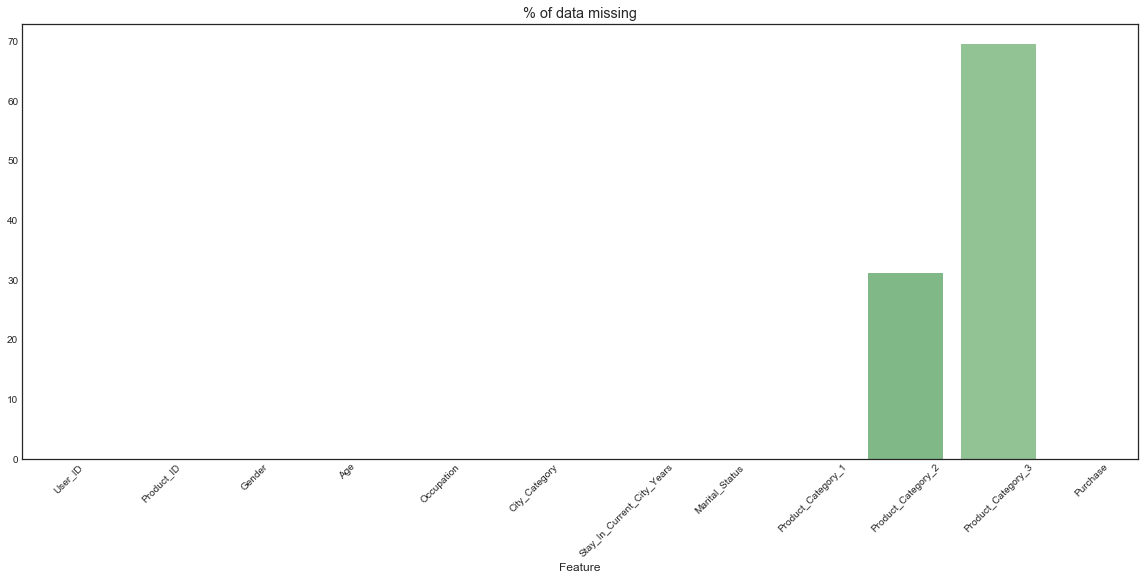

In [7]:
# Check for missing values
plt.figure(figsize=(20,8))
plt.title('% of data missing')
plt.xlabel("Feature")
plt.xticks(rotation = 45)
sns.barplot(x = df.columns, palette="Greens_d", y = df.isnull().sum()/537577 *100)

## We can see there is a lot of data missing from features Product_Category_2 (31%) and Product_Category_3 (69%)
### After meeting with the business unit we decided to drop the product category features as our target variable is to use multinomial logit model to predict what is the probability of purchase for a product ID based on demographic data

In [8]:
# Drop Product Category Columns
df.drop(columns = ['Product_Category_1','Product_Category_2','Product_Category_3'], inplace = True)

In [9]:
# Recheck dataframe for missing values
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Purchase                      0
dtype: int64

In [10]:
print("The new shape of our dataframe is {}".format(df.shape[0]) + " rows, and {}".format(df.shape[1]) + " columns")

The new shape of our dataframe is 537577 rows, and 9 columns


### Our dataset still has 537577 rows before and after dropping the 3 product category features.

In [11]:
# Check the data types of our features
df.dtypes

User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                 int64
Purchase                       int64
dtype: object

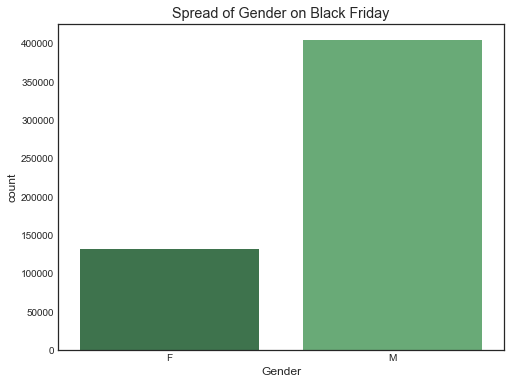

In [12]:
# Majority of customers were male
plt.title("Spread of Gender on Black Friday")
sns.countplot(df['Gender'], palette="Greens_d")

Text(0.5,1,'Purchase behavior based on Gender')

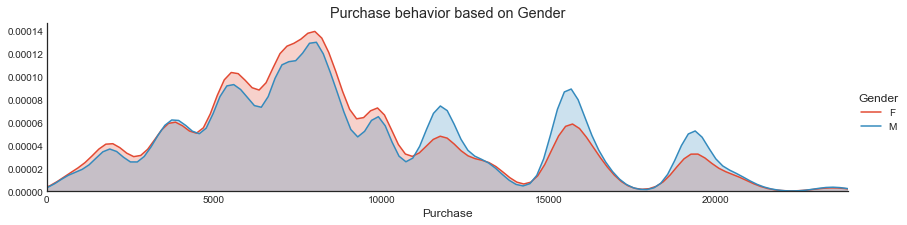

In [13]:
# Compare Male vs Female Spending Distributions
plot_distribution(df, var = 'Purchase', target = 'Gender')
plt.title('Purchase behavior based on Gender')

Text(0.5,1,'Boxplot of Marital Status and Gender Purchase Behavior')

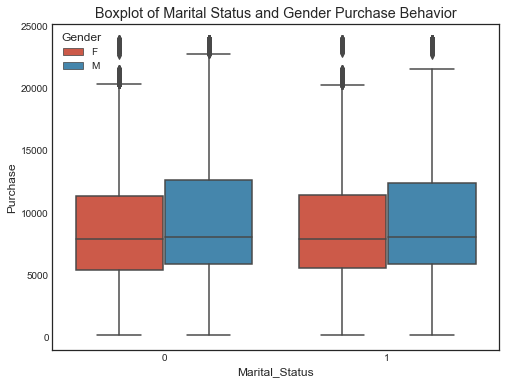

In [14]:
sns.boxplot(x="Marital_Status", y="Purchase", hue="Gender", data=df)
plt.title("Boxplot of Marital Status and Gender Purchase Behavior")

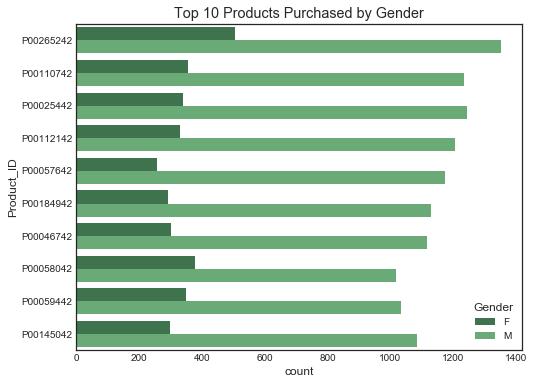

In [15]:
plt.title("Top 10 Products Purchased by Gender")
sns.countplot(data = df, y = 'Product_ID', hue = 'Gender', palette="Greens_d", order=df['Product_ID'].value_counts().iloc[:10].index)

In [16]:
# Create dummie variables for Gender
gender = pd.get_dummies(df['Gender'])
# Concatenate dummie variables back to the original dataframe
df = pd.concat([df, gender], axis = 1)
# Drop the previous feature for "Gender"
df.drop(columns = 'Gender', inplace = True)
# Check the head of the DataFrame and verify
df.head()

,User_ID,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M
0,1000001,P00069042,0-17,10,A,2,0,8370,1,0
1,1000001,P00248942,0-17,10,A,2,0,15200,1,0
2,1000001,P00087842,0-17,10,A,2,0,1422,1,0
3,1000001,P00085442,0-17,10,A,2,0,1057,1,0
4,1000002,P00285442,55+,16,C,4+,0,7969,0,1


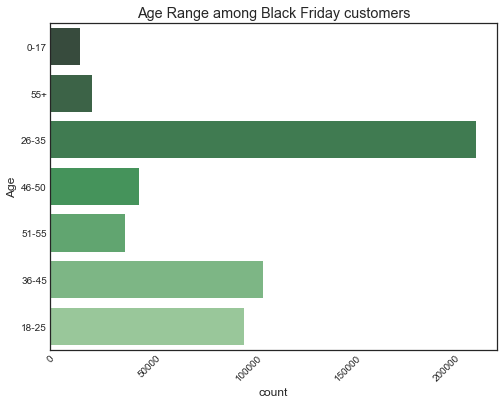

In [17]:
# Majority of consumers fall into 26-35 range
plt.title("Age Range among Black Friday customers")
plt.xticks(rotation = 45)
sns.countplot(data = df, y = 'Age', palette = 'Greens_d')

Text(0.5,1,'Purchase behavior based on Age Bins')

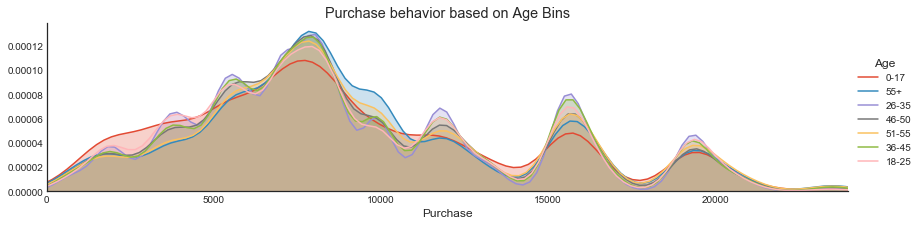

In [18]:
# Compare Age Range Spending Disitrbutions
plot_distribution(df, var = 'Purchase', target = 'Age')
plt.title("Purchase behavior based on Age Bins")

In [19]:
# Create Dummie variables for the Age feature
age = pd.get_dummies(df['Age'], prefix = "Age")
# Concatenate the dummie variables ot the orignal dataframe
df = pd.concat([df, age], axis =1)
df.drop(columns = 'Age', inplace = True)
df.head()

,User_ID,Product_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,P00069042,10,A,2,0,8370,1,0,1,0,0,0,0,0,0
1,1000001,P00248942,10,A,2,0,15200,1,0,1,0,0,0,0,0,0
2,1000001,P00087842,10,A,2,0,1422,1,0,1,0,0,0,0,0,0
3,1000001,P00085442,10,A,2,0,1057,1,0,1,0,0,0,0,0,0
4,1000002,P00285442,16,C,4+,0,7969,0,1,0,0,0,0,0,0,1


Text(0.5,1,'Purchase Behavior based on Marital Status')

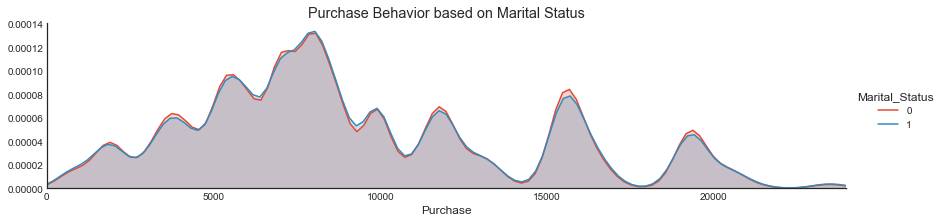

In [20]:
plot_distribution(df = df, var = 'Purchase', target = 'Marital_Status')
plt.title("Purchase Behavior based on Marital Status")

Text(0.5,1,'Purchase behavior based on duration of residence')

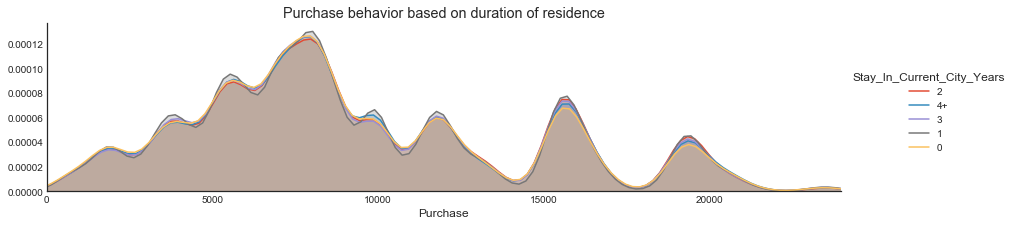

In [21]:
plot_distribution(df, var = 'Purchase', target = 'Stay_In_Current_City_Years')
plt.title("Purchase behavior based on duration of residence")

Text(0.5,1,'Purchase behavior based on Occupation')

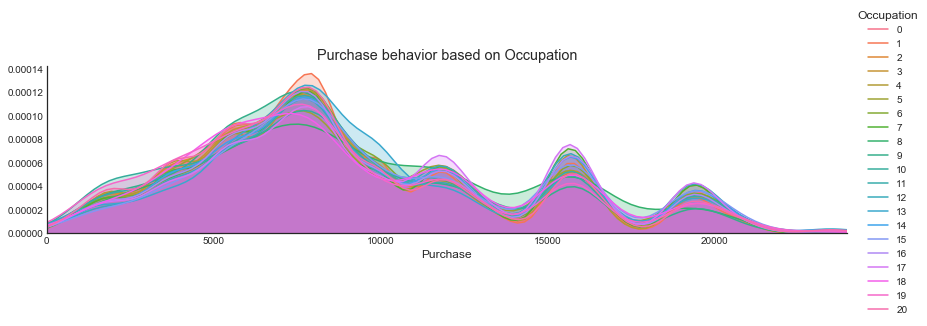

In [22]:
plot_distribution(df, var = 'Purchase', target ='Occupation')
plt.title("Purchase behavior based on Occupation")

In [23]:
# Encode/transform categorical variables 'City_Category', 'Stay_In_Current_City_Years' and 'Occupation'
le = LabelEncoder()
df['City_Category'] = le.fit_transform(df['City_Category'])
df['Stay_In_Current_City_Years'] = le.fit_transform(df['Stay_In_Current_City_Years'])
df['Occupation'] = le.fit_transform(df['Occupation'])
df.head()

,User_ID,Product_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,P00069042,10,0,2,0,8370,1,0,1,0,0,0,0,0,0
1,1000001,P00248942,10,0,2,0,15200,1,0,1,0,0,0,0,0,0
2,1000001,P00087842,10,0,2,0,1422,1,0,1,0,0,0,0,0,0
3,1000001,P00085442,10,0,2,0,1057,1,0,1,0,0,0,0,0,0
4,1000002,P00285442,16,2,4,0,7969,0,1,0,0,0,0,0,0,1


In [24]:
# Drop User_ID column
df.drop(columns = ['User_ID','Purchase'], inplace = True)
df.head()

,Product_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,P00069042,10,0,2,0,1,0,1,0,0,0,0,0,0
1,P00248942,10,0,2,0,1,0,1,0,0,0,0,0,0
2,P00087842,10,0,2,0,1,0,1,0,0,0,0,0,0
3,P00085442,10,0,2,0,1,0,1,0,0,0,0,0,0
4,P00285442,16,2,4,0,0,1,0,0,0,0,0,0,1


In [24]:
# Split our dataset into X and y
#df.columns
X = df[['Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status','F','M','Age_0-17','Age_18-25','Age_26-35','Age_36-45','Age_46-50','Age_51-55','Age_55+']]
y = df['Product_ID']

In [25]:
# Convert X and y to arrays
X = np.array(X)
y = np.array(y)

In [26]:
# Instantiate a standard scaler
sc = StandardScaler()

In [27]:
# Normalize our dataset and split into X
X = sc.fit_transform(X)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [40]:
# Instantiate a LogisiticRegression class
lr = LogisticRegression()

In [28]:
# Split training dataset into X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### You will notice I dropped Purchase feature earlier to prevent input to the model. This is because purchase price is directly correlated with product ID, as each product ID has a set price, thus introudcing bias into said model

### Logistic Regression Classifier

In [ ]:
# Fit our Logistic Regression model to the training dataset
logreg = lr.fit(X_train, y_train)
print("The coefficients of our logreg model are " + str(list(logreg.coef_)))
print("The intercept of our logreg model is " + str(logreg.intercept_))

### Decision Tree Classifier

In [36]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
print("The accuracy of our Decision Tree model is " + str(classifier.score(X_train, y_train)*100) + "%")

The accuracy of our Decision Tree model is 0.9875343265257719%


In [37]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [38]:
# Compare the precision, recal, and f1-score between our predicted values y_pred) and our real test values (y_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  P00000142       0.00      0.01      0.00       235
  P00000242       0.00      0.00      0.00        78
  P00000342       0.00      0.01      0.00        67
  P00000442       0.00      0.00      0.00        19
  P00000542       0.00      0.00      0.00        30
  P00000642       0.00      0.00      0.00       109
  P00000742       0.00      0.00      0.00        46
  P00000842       0.00      0.00      0.00         8
  P00000942       0.00      0.00      0.00        17
  P00001042       0.00      0.00      0.00       110
  P00001142       0.00      0.00      0.00       104
  P00001242       0.00      0.00      0.00        17
  P00001342       0.00      0.00      0.00         6
  P00001442       0.00      0.00      0.00        19
  P00001542       0.00      0.00      0.00         8
  P00001642       0.00      0.00      0.00        64
  P00001742       0.00      0.01      0.00        84
  P00001842       0.00      0.00      0.00   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
print("The accuracy of our Logistic Regression model is " + str(logreg.score(X_train, y_train)*100) + "%")

In [ ]:
# Take our same fitted Logistic Regression model and use it to create a new predicted feature 'y_pred'
y_pred = logreg.predict(X_test)

In [ ]:
# Compare the precision, recal, and f1-score between our predicted values y_pred) and our real test values (y_test)
print(classification_report(y_test, y_pred))

In [39]:
# Confusion matrix shows the hit rate
print(confusion_matrix(y_test, y_pred))

[[ 2  8  5 ...  0  0  0]
 [12  0  0 ...  0  0  0]
 [ 5  1  1 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 3  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]]


In [40]:
print("The accuracy of our Decision Tree model on the test data is " + str(classifier.score(X_test, y_test)*100) + "%")

The accuracy of our Decision Tree model on the test data is 0.05301536515495368%


### Our model only lost a 0.7% dip in accuracy from training data to test data

### Question 1
Use the Relay train data to develop a model to predict customer retention. You
may use logistic regression to predict the variable "retained." You can use any
combination of the independent variables available in the data to obtain a model
with the best predictive ability and usability. You are free to use different
transformations and combinations of the independent variables. Be aware that
there is no “magic bullet” to finding the ideal model. You will have to go through
multiple iterations.

In [ ]:
print(logreg)

In [ ]:
print("The accuracy of our Logistic Regression model is " + str(logreg.score(X_train, y_train)*100) + "%")

In [ ]:
print("The coefficients of our logreg model are " + str(logreg.coef_))

In [ ]:
print("The intercept of our logreg model is " + str(logreg.intercept_))

### Question 2
Once you obtain the best model that you can find, predict retention in the test
data. You will use the coefficients obtained from the model estimated using the
train data to do this. Name this predicted value "pretain."

In [ ]:
print(classification_report(y_test, y_pred))

### Question 3
Calculate the hit rate. This can be calculated as % of matches between the value
of pretain and retained in the train data.

In [ ]:
print(confusion_matrix(y_test, y_pred))

### Question 4
Be prepared to present your results in class. The team with the best model, as
judged by your peers, will win "bragging rights."